<a href="https://colab.research.google.com/github/toaomalkster/conscious-calculator-notebooks/blob/main/src/scratch/notebooks/number-adder/NumberAdder_0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Number Adder
0.5:
* Continuation of a re-inforcement style loss function across looped model:
  * Input presented only on first iteration
  * Has 'status' output nodes
  * Loss measures ability to produce a >1.0 status with a correct result.

## Background
Building up towards a model based on Consciousness V2 theory.

## Loss Function Considerations
Non-negotiables:
* Must produce the correct result at some point
* Must not falsely represent the result -- ie: if there is a 'completion' flag, then it must always be close to zero if not outputting the result

Fuzzy requirements:
* Accuracy is more important than efficiency
* Needs to identify 'completion' somehow

Ideal optimisation requirements:
* Minimise effort to produce result
  * Optimises for quicker response times
  * Also a protection against infinite loops

**App Boilerplate**

In [175]:

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(tf.__version__)


2.3.0


# Setup Training Data

In [176]:
data = np.random.randint(100, size=(1000, 2)).astype('float32')
data[0:10,:]

array([[ 5., 77.],
       [ 1., 87.],
       [41.,  0.],
       [62., 82.],
       [15., 16.],
       [96.,  3.],
       [56., 93.],
       [80., 29.],
       [68., 94.],
       [74., 33.]], dtype=float32)

In [177]:
data_labels = (data[:,0] + data[:,1])[:,np.newaxis]
data_labels[0:10,:]

array([[ 82.],
       [ 88.],
       [ 41.],
       [144.],
       [ 31.],
       [ 99.],
       [149.],
       [109.],
       [162.],
       [107.]], dtype=float32)

# Setup Model

In [178]:
statusNodes=1
outputNodes=1
feedbackNodes=5
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(2+feedbackNodes,)),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dense(statusNodes + outputNodes + feedbackNodes)
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1000)              8000      
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 7007      
Total params: 15,007
Trainable params: 15,007
Non-trainable params: 0
_________________________________________________________________


# Setup Training
Running equivalent of:
```
# fitres = model.fit(data, data_labels, validation_split=0.2, shuffle=True, epochs=150)
```

Trained to run with loop length 5, and asked to calculate 78 + 14, gives the following sub-results:
```
(tbd)
```
And the following final result:
```
(tbd)
```

In [179]:
loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
a_true = tf.ones(shape=(5, 1))
a_preds = tf.constant([
                       [[0.0], [0.8], [0.9]],
                       [[1.0], [1.1], [1.2]],
                       [[2.0], [2.1], [2.2]],
                       [[2.5], [0.1], [0.2]],
                       [[0.5], [0.2], [0.4]]
])

#print(a_true)
#print(a_preds)
#loss(a_true, a_preds)
#a_preds[0]
#a_preds.shape

#loss(a_true, a_preds[:,1,...])
#loss(a_true, a_preds)

print(f'a_preds.shape={a_preds.shape}')
#tf.unstack(a_preds, axis=1)[0]
l0 = loss(a_true, tf.unstack(a_preds, axis=1)[0])
l1 = loss(a_true, tf.unstack(a_preds, axis=1)[1])
print(l0)
print(l1)
#tf.stack([l0,l1],axis=1)
#tf.stack([[i*2] for i in range(0,5)])
#tf.map_fn(fn=lambda y_pred: loss(y_true, y_pred), elems=tf.unstack(a_preds, axis=1), fn_output_signature=tf.float32)

losses = tf.stack([loss(y_true, y_pred) for y_pred in tf.unstack(a_preds, axis=1)], axis=1)
print(f'losses.shape={losses.shape}')

a_preds.shape=(5, 3, 1)
tf.Tensor([1.   0.   1.   2.25 0.25], shape=(5,), dtype=float32)
tf.Tensor([0.04       0.01       1.2099998  0.80999994 0.64000005], shape=(5,), dtype=float32)
losses.shape=(5, 3)


In [180]:
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
a_true = tf.ones(shape=(5, 1))
a_preds = tf.constant([
                       [[0.0, 0.0], [0.0, 0.8], [0.0, 0.9]],
                       [[0.0, 1.0], [0.0, 1.1], [0.0, 1.2]],
                       [[0.0, 2.2], [0.0, 2.1], [0.0, 2.3]],
                       [[0.0, 2.5], [0.0, 0.1], [0.0, 0.2]],
                       [[0.0, 0.5], [0.0, 0.2], [0.0, 0.4]]
])


#@tf.function
def multiIterationLoss(y_true, y_preds):
  """Computes re-inforcement loss across loop execution.

  Args:
    y_true: Ground truth values.
            Expected outcome, excluding status or feedback nodes.
            shape = `(batch_size, output_nodes)`.
    y_preds: The predicted values across all iterations of the loop.
            Includes status, but excludes feedback nodes.
            shape = `(batch_size, loop_size, status_nodes + output_nodes)`.

  Returns:
    Mean absolute squares values. shape = `(1)`.
  """

  # REMEMBER: all operations are actioned ACROSS the whole batch

  # Plan:
  #  Loss Part A: must produce correct result it at least one iteration
  #  Loss Part B: must yield >1.0 status against best result
  #  Loss Part C: must NOT yield >1.0 status against wrong results

  # Collect losses across batch and iterations
  # maps: y_preds(bs, ls, sn+on) -> losses(bs, ls)    // ignoring status_nodes
  # (note: mse is batch aware but configured to NOT sum across the batch,
  #  so we'll need to manually do that sum at the end)
  losses = tf.stack([
                     mse(y_true, y_pred[:,1:, ...])
                     for y_pred in tf.unstack(y_preds, axis=1)],
                    axis=1)
  print(f'losses across batch and iterations:\n{losses}')

  # Loss Part A: must produce correct result it at least one iteration
  # (so take min loss across iterations)
  #minLoss        = tf.min(losses, axis=1)
  minLossIndices = tf.argmin(losses, axis=1)
  minLoss        = tf.gather(losses, minLossIndices, batch_dims=1, axis=1)
  print(f'min loss per-batch across iterations (indices {minLossIndices}):\n{minLoss}')

  batchLoss = tf.reduce_sum(minLoss)
  print(f'batch loss: {batchLoss}')

  # Loss Part A: must produce correct result it at least one iteration
  #bestLoss = None
  #bestI = None
  #for i in range(y_preds.shape[0]):
  #  y_pred = y_preds[i]
  #  ls = loss(y_true, y_pred[1:, ...])
  #  if bestLoss == None or ls < bestLoss:
  #    bestLoss = ls
  #    bestI = i
  #print(f'best loss: {bestLoss} @ {bestI}')
  
  # Loss Part B: must yield >=1.0 status against best result
  #statusLoss
  #if y_preds[bestI][0] < 1.0
  #  statusLoss = loss([10.0], y_preds[bestI][0])

  # Loss Part C: must NOT yield >=1.0 status against wrong results

  #return bestLoss
  print('done.')
  return batchLoss

print(multiIterationLoss(a_true, a_preds))

losses across batch and iterations:
[[1.         0.04       0.01      ]
 [0.         0.01       0.04000002]
 [1.44       1.2099998  1.6899998 ]
 [2.25       0.80999994 0.64000005]
 [0.25       0.64000005 0.36      ]]
min loss per-batch across iterations (indices [2 0 1 2 0]):
[0.01       0.         1.2099998  0.64000005 0.25      ]
batch loss: 2.109999895095825
done.
tf.Tensor(2.11, shape=(), dtype=float32)


In [181]:
optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Returns: y_preds - list of preds, where each y_pred is a tensor of shape = `(batch_size, d0, .. dN)`.
@tf.function
def compute(inputs, max_loop_length, training=False):
  batchSize = inputs.shape[0]
  outputs = []
  feedback = tf.zeros(shape=(batchSize, feedbackNodes))

  for i in range(max_loop_length):
    # extend width of inputs with zeroed-out feedback
    if i == 0:
      inputsWithFeedback = tf.concat([inputs, feedback], axis=1)
    else:
      zeroedInputs = tf.zeros(shape=inputs.shape)
      inputsWithFeedback = tf.concat([zeroedInputs, feedback], axis=1)
  
    # run model with inputs + feedback nodes
    output = model(inputsWithFeedback, training)

    # copy feedback for next iteration
    feedback = output[:,-feedbackNodes:]

    # produce output for records
    # (note: doesn't use TF functions so don't re-use any of this for next iteration)
    outputs.append(output[:,:-feedbackNodes])

  return tf.stack(outputs, axis=1)

# TODO
def predict(inputs, max_loop_length, training=False):
  # pick last iteration's output only and omit status nodes
  return compute(inputs, max_loop_length, training)[:,-1,statusNodes:]

@tf.function
def train_step(inputs, expected, max_loop_length):
  with tf.GradientTape() as tape:
    outputs = compute(inputs, max_loop_length, training=True)

    # calculate loss ignoring feedback output
    loop_loss = multiIterationLoss(expected, outputs)

    # train model
    gradients = tape.gradient(loop_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loop_loss

In [182]:
def fit(train_data, train_labels, epochs, batch_size, max_loop_length):
  res = {}
  res['loss'] = []

  for epoch in range(epochs):
    print ('Epoch: {}/{}'.format(epoch+1, epochs))
    start = time.time()
    sum_loss = 0

    # Train in batches
    mx = (int(len(train_data)/batch_size))*batch_size
    n  = mx/batch_size
    print ('[', end='')
    for i in range(0, mx, batch_size):
      batch_data   = train_data[i:i+batch_size]
      batch_labels = train_labels[i:i+batch_size]
      sum_loss += train_step(batch_data, batch_labels, max_loop_length)
      print ('=', end='')
    print('] - {} sec - loss: {}'.format(time.time()-start, sum_loss/n))

    # Record history
    res['loss'].append(sum_loss/n)

  return res

# Run Training

In [183]:
fitres = fit(data, data_labels, epochs=150, batch_size=32, max_loop_length=5)

Epoch: 1/150
[losses across batch and iterations:
Tensor("stack:0", shape=(32, 5), dtype=float32)
min loss per-batch across iterations (indices Tensor("ArgMin:0", shape=(32,), dtype=int64)):
Tensor("GatherV2:0", shape=(32,), dtype=float32)
batch loss: Tensor("Sum:0", shape=(), dtype=float32)
done.
losses across batch and iterations:
Tensor("stack:0", shape=(32, 5), dtype=float32)
min loss per-batch across iterations (indices Tensor("ArgMin:0", shape=(32,), dtype=int64)):
Tensor("GatherV2:0", shape=(32,), dtype=float32)
batch loss: Tensor("Sum:0", shape=(), dtype=float32)
done.
===============================] - 0.7227749824523926 sec - loss: 268901.78125
Epoch: 2/150
[===============================] - 0.0542604923248291 sec - loss: 157590.28125
Epoch: 3/150
[===============================] - 0.06244158744812012 sec - loss: 73985.5078125
Epoch: 4/150
[===============================] - 0.05834197998046875 sec - loss: 23932.28515625
Epoch: 5/150
[===============================] - 0.06

# Results

In [184]:
print(['x', 'y', 'expected', 'actual'])
print(np.concatenate((data[800:810], data_labels[800:810], predict(data[800:810], 5)), axis=1))

['x', 'y', 'expected', 'actual']
[[3.30000000e+01 6.80000000e+01 1.01000000e+02 1.23463243e-01]
 [1.70000000e+01 1.30000000e+01 3.00000000e+01 1.23833977e-01]
 [3.50000000e+01 9.60000000e+01 1.31000000e+02 1.23275906e-01]
 [3.60000000e+01 6.20000000e+01 9.80000000e+01 1.23423450e-01]
 [6.50000000e+01 2.60000000e+01 9.10000000e+01 1.23305783e-01]
 [5.70000000e+01 8.70000000e+01 1.44000000e+02 1.22991778e-01]
 [7.80000000e+01 7.70000000e+01 1.55000000e+02 1.22749247e-01]
 [7.00000000e+00 8.50000000e+01 9.20000000e+01 1.23465419e-01]
 [4.50000000e+01 3.30000000e+01 7.80000000e+01 1.23418018e-01]
 [3.40000000e+01 8.40000000e+01 1.18000000e+02 1.23373792e-01]]


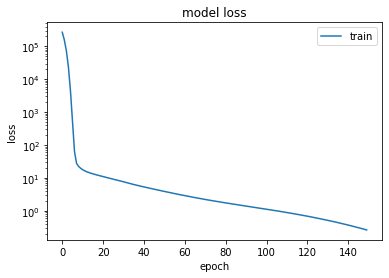

In [185]:
plt.semilogy(fitres['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

# Analysis

In [187]:
print(compute(data[800:810], 6))

tf.Tensor(
[[[-8.11963081e-02  1.01008568e+02]
  [ 9.13317323e-01  5.22997332e+00]
  [-5.82686365e-02  2.67587692e-01]
  [ 9.21471044e-04  1.25225425e-01]
  [-1.55253452e-03  1.23463243e-01]
  [ 3.25103756e-05  1.24129191e-01]]

 [[-6.71187639e-01  3.02151031e+01]
  [ 2.64416933e-01  1.41335523e+00]
  [-2.32463069e-02  1.39013276e-01]
  [ 4.93781525e-04  1.24041200e-01]
  [-6.26108900e-04  1.23833977e-01]
  [ 2.73562036e-05  1.24127410e-01]]

 [[ 7.14787006e-01  1.30956497e+02]
  [ 1.22873282e+00  6.94231653e+00]
  [-6.86744228e-02  3.35029215e-01]
  [ 1.14291534e-03  1.28138289e-01]
  [-1.90740603e-03  1.23275906e-01]
  [ 4.23414167e-05  1.24130324e-01]]

 [[-4.33419466e-01  9.80281067e+01]
  [ 8.78434062e-01  4.97749138e+00]
  [-5.96974865e-02  2.65652359e-01]
  [ 1.23419159e-03  1.25565350e-01]
  [-1.58069946e-03  1.23423450e-01]
  [ 3.05871945e-05  1.24126852e-01]]

 [[-3.17474461e+00  9.10611420e+01]
  [ 7.54891336e-01  3.94654799e+00]
  [-8.32300484e-02  3.14152092e-01]
  [ 2.933

In [186]:
predict(data[800:810], 6)

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.12412919],
       [0.12412741],
       [0.12413032],
       [0.12412685],
       [0.12411825],
       [0.12412357],
       [0.12411952],
       [0.12413429],
       [0.12412457],
       [0.12413003]], dtype=float32)>